# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, \
    plot_true_pred, plotComparisonShapleyValues, plotMultipleSV, plotMultipleSV_4, plotShapleyValue

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

# Util Functions

In [4]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [5]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [6]:
## Function for substituting gender of a given itemset
substitute_gender = lambda x : "gender=Male" if "gender=Female" in x else ("gender=Female" if "gender=Male" in x else x)

## Function for substituting field of a given itemset
substitute_field = lambda x : "field=Far" if "field=Close" in x else ("field=Close" if "field=Far" in x else x)

In [7]:
n = 3  # Number of subgroups to visualize
K = 25  # Global Shapley values to visualize

In [8]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = {'total_silence': 'tot_silence', \
                  'trimmed': 'trim', \
                  'total_': 'tot_', \
                  'speed_rate_word': 'speakRate', \
                  'speed_rate_char': 'speakCharRate', \
                  'duration': 'dur'}

abbreviations_shorter = abbreviations.copy()

# Define targets

In [9]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [10]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [11]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender', 'language', 'field']

slot_cols = ['scenario', 'action']

signal_cols = ['total_silence','total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + slot_cols + signal_cols 

# Retrieve Data and Compute Divergence

In [12]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [13]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "SLURP", f"SLURP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])

    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base


wav2vec2-large
hubert-base
hubert-large


In [14]:
## Check if the accuracy of the models is as expected
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))

Accuracy of wav2vec2-base: 86.863
Accuracy of wav2vec2-large: 85.586
Accuracy of hubert-base: 87.697
Accuracy of hubert-large: 89.249


In [15]:
W2V2_BASE_ACC = 86.86
W2V2_LARGE_ACC = 85.59
HUB_BASE_ACC = 87.70
HUB_LARGE_ACC = 89.25

In [16]:
## Check gender subgroups' accuracy
for config in configs:
    print(config)
    print(filter_itemset_df_by_attributes(FP_fm_dict[config],['gender'], alls = True)\
        [['itemsets', 'accuracy', 'd_accuracy', 't_value']]\
        .sort_values('d_accuracy', ascending = False))
    print("----------")


## Check language subgroups' accuracy
for config in configs:
    print(config)
    print(filter_itemset_df_by_attributes(FP_fm_dict[config],['language'], alls = True)\
        [['itemsets', 'accuracy', 'd_accuracy', 't_value']]\
        .sort_values('d_accuracy', ascending = False))
    print("----------")

wav2vec2-base
             itemsets  accuracy  d_accuracy  t_value
1     (gender=Female)   0.87552     0.00689     1.43
425  (gender=Unknown)   0.86328    -0.00536     0.58
23      (gender=Male)   0.85742    -0.01121     1.83
----------
wav2vec2-large
             itemsets  accuracy  d_accuracy  t_value
1     (gender=Female)   0.86381     0.00795     1.59
425  (gender=Unknown)   0.84817    -0.00769     0.77
23      (gender=Male)   0.84362    -0.01224     1.92
----------
hubert-base
             itemsets  accuracy  d_accuracy  t_value
1     (gender=Female)   0.88150     0.00453     0.96
425  (gender=Unknown)   0.87599    -0.00098     0.16
23      (gender=Male)   0.86880    -0.00817     1.38
----------
hubert-large
             itemsets  accuracy  d_accuracy  t_value
1     (gender=Female)   0.89737     0.00488     1.10
23      (gender=Male)   0.88574    -0.00675     1.22
425  (gender=Unknown)   0.88474    -0.00775     0.88
----------
wav2vec2-base
               itemsets  accuracy  d_acc

In [17]:
## Test Samples
config = 'wav2vec2-base'
print("Test Samples: ", len(df_dict[config]))
print("Subgroup Explored: ", len(FP_fm_dict[config]))

Test Samples:  13078
Subgroup Explored:  3896


In [18]:
import time

overall_time = []

for i in range(10):

    config = "wav2vec2-base"

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "SLURP", f"SLURP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)

    start_time = time.time()
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    # print("--- %s seconds ---" % (time.time() - start_time))
    overall_time.append(time.time() - start_time)

print("Average time: ", np.mean(overall_time))
print("Worst time: ", np.max(overall_time))

Average time:  0.8341533660888671
Worst time:  0.8872277736663818


# Divergence Wav2Vec2-Base

In [19]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [20]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
1721,action=quirky,0.05,67.367,-19.497,10.27
3873,"field=Far, scenario=general",0.03,68.020,-18.843,8.02
1174,scenario=general,0.06,71.921,-14.943,9.03


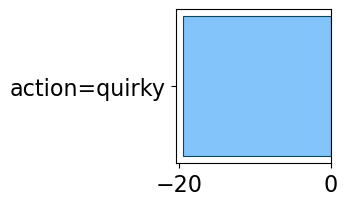

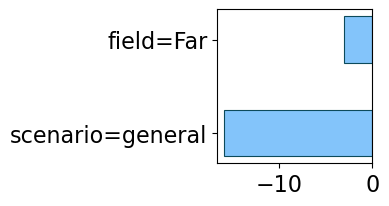

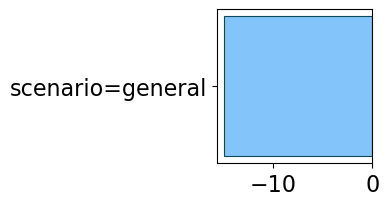

In [21]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    for i in range(len(pr)):
        itemset_1 = pr.iloc[i].itemsets
        itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
        itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
        plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                        sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

In [22]:
## Does not exist for this support threshold
# positive_itemset = frozenset({'filed=close', 'scenario=general'})
# FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
# pr_pi = FPdiv.copy()
# print(pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100)

# itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
# for key in itemset_shap:
#     itemset_shap[key] = itemset_shap[key]*100
# fp_divergence_i.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
#                                 sizeFig=(2,2))

In [23]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
3889,"gender=Female, scenario=weather",0.03,95.929,9.065,8.32
3877,"action=query, n_words=medium, tot_silence=medium",0.03,95.431,8.568,7.50
3085,"action=query, scenario=email",0.03,95.122,8.259,7.52


In [24]:
positive_itemset = frozenset({'scenario=weather'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_pi = FPdiv.copy()
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_BASE_ACC,3))

Accuracy:  94.428
Δ_Acc:  7.568


Individual Divergence


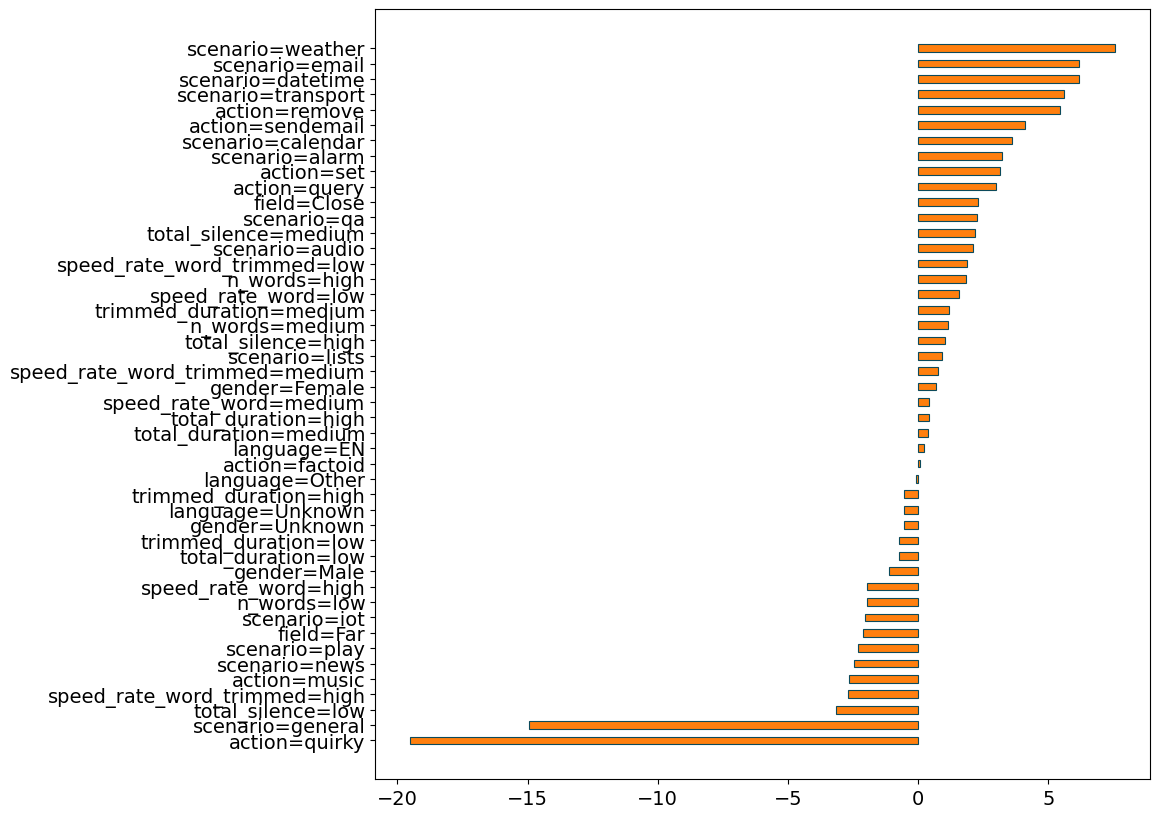

---------------

Global Divergence


/home/akoudounas/miniconda3/envs/speech/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


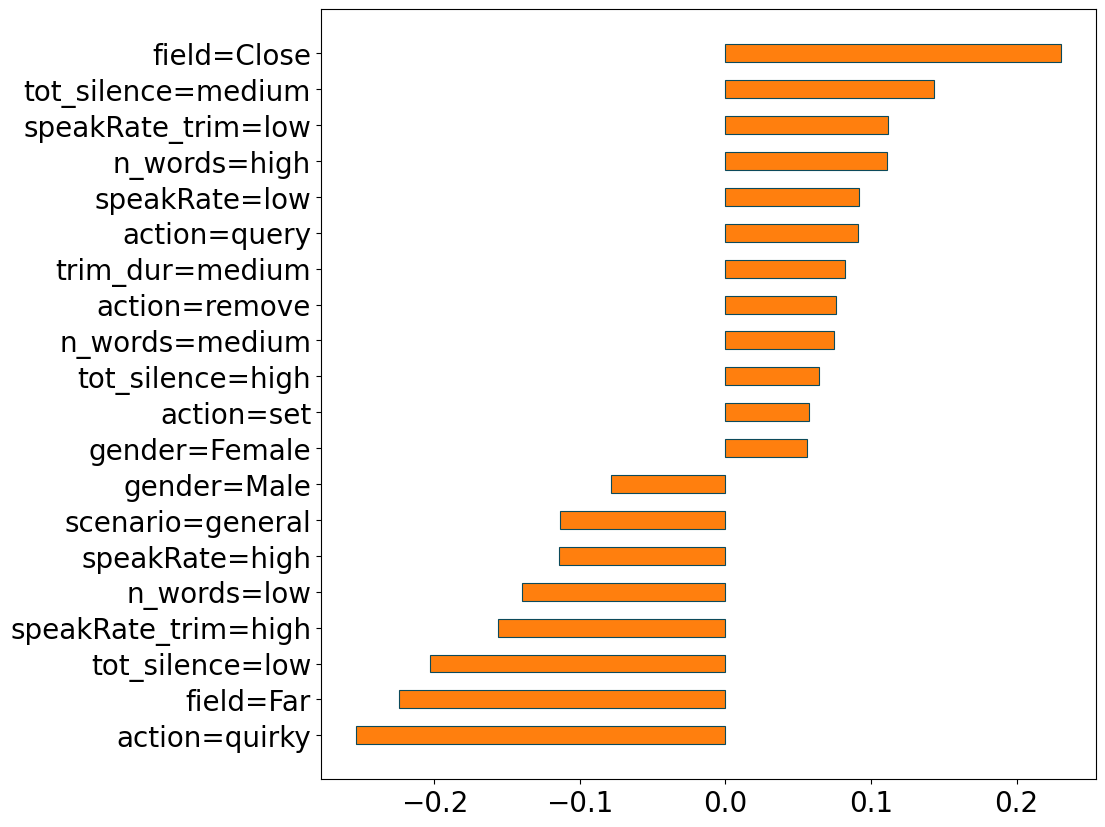

In [25]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=14, titlesize=14)
print("---------------\n")

print("Global Divergence")
K = 20
global_item_divergence_wav2b = fp_divergence_i.computeGlobalShapleyValue()
topK_global_wavb = {k:v*100 for k,v in global_item_divergence_wav2b.items() 
                if k in sorted(global_item_divergence_wav2b, 
                key=lambda x: abs(global_item_divergence_wav2b[x]))[::-1][:K]} 

plotShapleyValue(shapley_values=abbreviateDict(topK_global_wavb, abbreviations), 
                sizeFig=(10,10), labelsize=20, titlesize=20,
                saveFig=True, nameFig="plot_results/SLURP/w2v2b_global_divergence.pdf")

# Divergence Wav2Vec2-Large

In [26]:
## Compute the divergence for Wav2Vec2-Large (300m)
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

In [27]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
1721,action=quirky,0.05,68.174,-17.412,9.22
2723,"n_words=low, scenario=play, tot_dur=low, trim_dur=low",0.04,69.421,-16.165,7.69
2077,"n_words=low, scenario=play, trim_dur=low",0.04,70.304,-15.282,7.86


In [28]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
3085,"action=query, scenario=email",0.03,96.009,10.422,10.33
2650,"field=Close, scenario=email",0.04,94.705,9.118,8.37
2527,"language=Other, scenario=email",0.04,94.433,8.847,8.04


Accuracy:  82.89800000000001
Δ_Acc:  -2.692


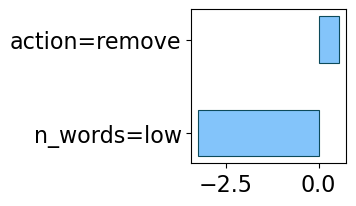

In [29]:
## Subgroup: {'action=remove', 'n_words=low'}
positive_itemset = frozenset({'action=remove', 'n_words=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_pi = FPdiv.copy()
acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", acc)
print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)


## The subgroup {'field=Far', 'speakRate_trim=high', 'n_words=low', 'trim_dur=high', 'language=English'}
# Does not exist for this support threshol

# negative_itemset = frozenset({'field=Far', 'speed_rate_word_trimmed=high', 'n_words=low', 'trimmed_duration=high', 'language=English'})
# FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
# pr = FPdiv.copy()
# acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
# print("Accuracy: ", acc)
# print("Δ_Acc: ", round(acc - W2V2_LARGE_ACC,3))

# itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
# itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
# plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
#                sizeFig=(2,2), labelsize=16, titlesize=16)

Individual Divergence


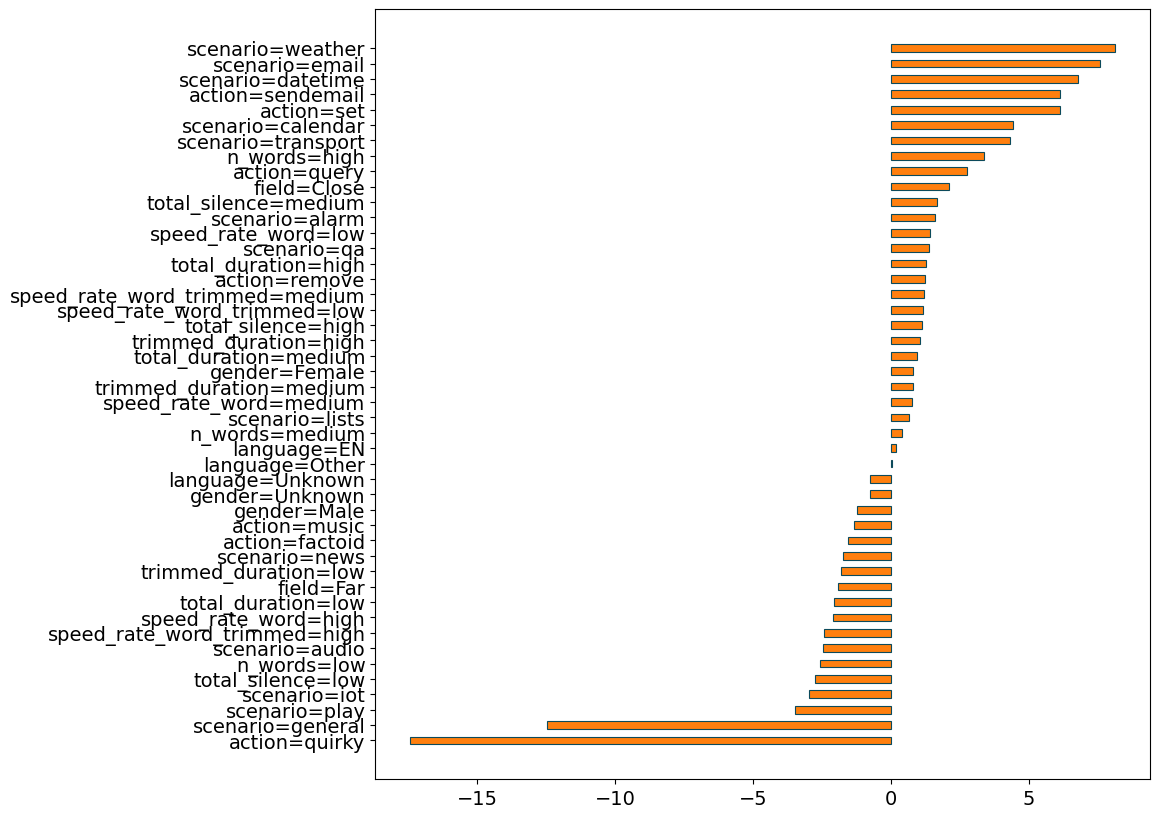

---------------

Global Divergence


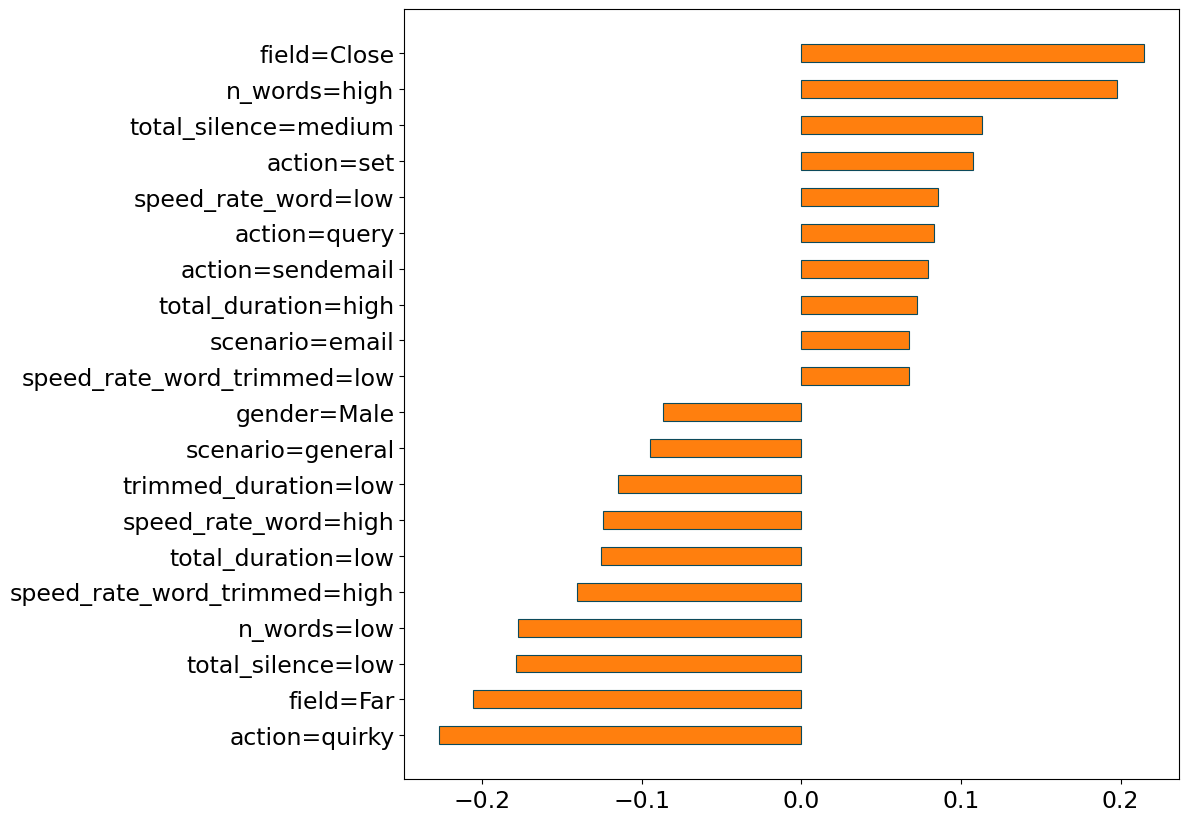

In [30]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=14, titlesize=14)
print("---------------\n")

print("Global Divergence")
global_item_divergence_wav2l = fp_divergence_i.computeGlobalShapleyValue()

topK_global_wavl = {k:v*100 for k,v in global_item_divergence_wav2l.items() 
                    if k in sorted(global_item_divergence_wav2l, 
                    key=lambda x: abs(global_item_divergence_wav2l[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_wavl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Base

In [31]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

In [32]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
3873,"field=Far, scenario=general",0.03,66.497,-21.199,8.91
1721,action=quirky,0.05,67.205,-20.492,10.78
1174,scenario=general,0.06,71.391,-16.306,9.81


In [33]:
## The subgroup {'filed=close', 'scenario=general'} does not exist for this support threshold

# positive_itemset = frozenset({'filed=close', 'scenario=general'})
# FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
# pr_pi = FPdiv.copy()
# acc = pr_pi[pr_pi['itemsets'] == positive_itemset].accuracy.values[0]*100
# print("Accuracy: ", acc)
# print("Δ_Acc: ", round(acc - HUB_BASE_ACC,3))

# itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
# itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
# plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
#                 sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

In [34]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
3634,"action=query, field=Close, gender=Female, trim_dur=medium",0.03,96.117,8.420,8.08
3733,"action=query, speakRate=low, speakRate_trim=low, trim_dur=medium",0.03,95.792,8.095,7.43
3555,"action=query, gender=Female, speakRate=low, tot_silence=medium",0.03,95.683,7.987,7.37


Individual Divergence


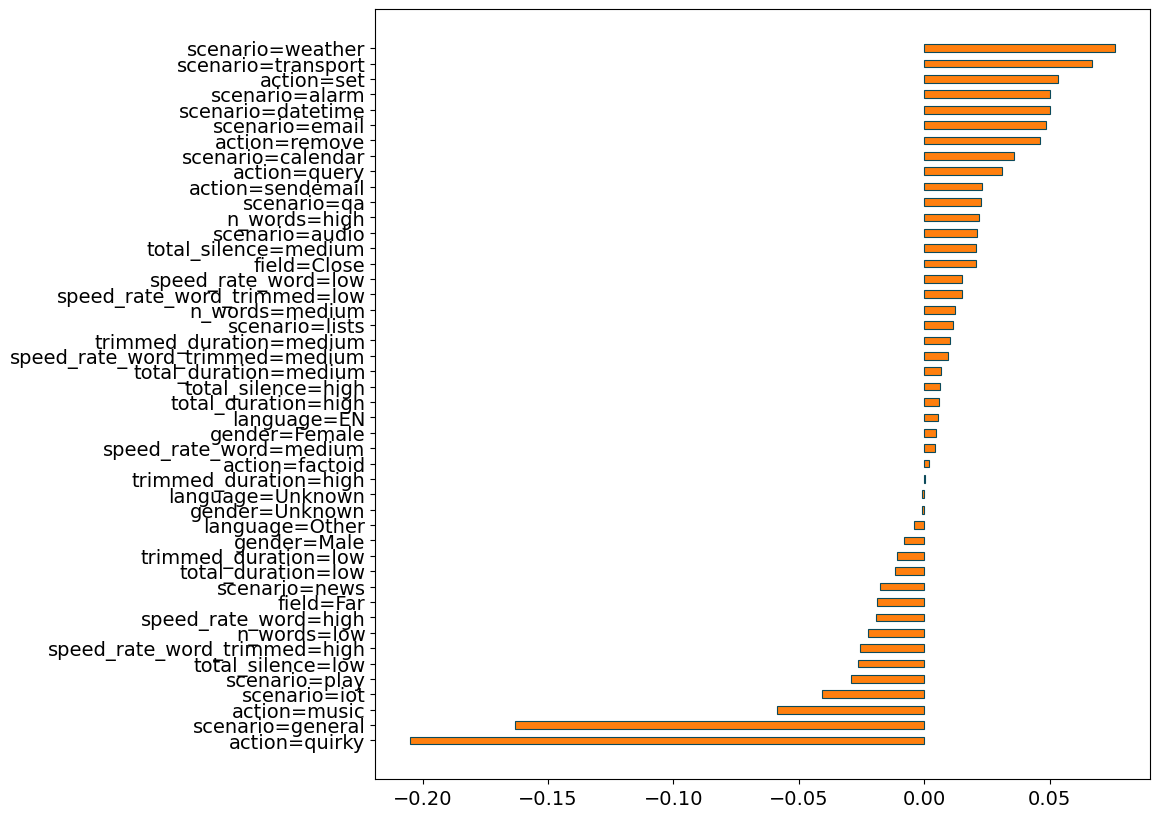

---------------

Global Divergence


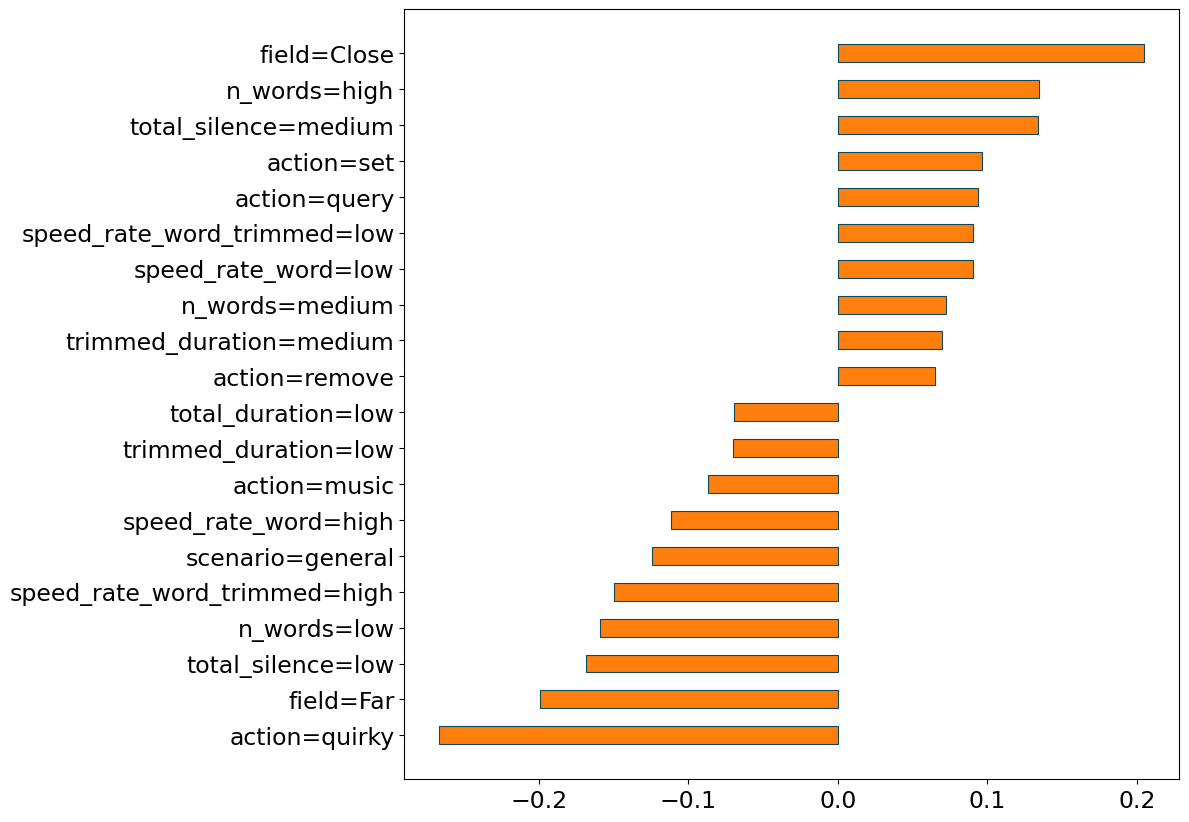

In [35]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=14, titlesize=14)
print("---------------\n")

print("Global Divergence")
global_item_divergence_hubb = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubb = {k:v*100 for k,v in global_item_divergence_hubb.items() 
                    if k in sorted(global_item_divergence_hubb, 
                    key=lambda x: abs(global_item_divergence_hubb[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubb, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence HuBERT-Large

In [36]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

In [37]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
2723,"n_words=low, scenario=play, tot_dur=low, trim_dur=low",0.04,77.273,-11.976,6.29
1721,action=quirky,0.05,77.706,-11.543,6.87
2077,"n_words=low, scenario=play, trim_dur=low",0.04,77.818,-11.432,6.49


In [38]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,accuracy,d_accuracy,t_value
3889,"gender=Female, scenario=weather",0.03,96.947,7.697,7.97
3562,"field=Far, n_words=high, scenario=calendar",0.03,96.643,7.394,7.59
3173,"action=set, n_words=high, scenario=calendar, trim_dur=high",0.03,96.614,7.365,7.77


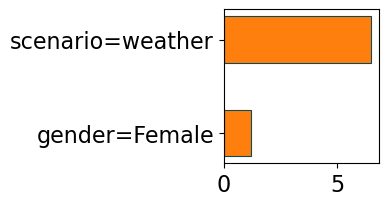

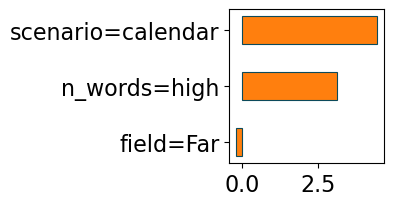

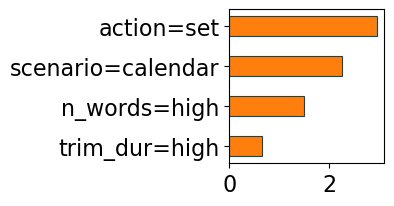

In [39]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    for i in range(len(pr)):
        itemset_1 = pr.iloc[i].itemsets
        itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
        itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
        plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                        sizeFig=(2,2), labelsize=16, titlesize=16)

In [40]:
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_pi = FPdiv.copy()

## Subgroup: {'n_words=high', 'scenario=calendar'}
positive_itemset = frozenset({'n_words=high', 'scenario=calendar'})
acc = pr_pi[pr_pi["itemsets"] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_LARGE_ACC,3))

## Subgroup: {'scenario=weather'}
positive_itemset = frozenset({'scenario=weather'})
acc = pr_pi[pr_pi["itemsets"] == positive_itemset].accuracy.values[0]*100
print("Accuracy: ", round(acc,3))
print("Δ_Acc: ", round(acc - HUB_LARGE_ACC,3))

Accuracy:  95.969
Δ_Acc:  6.719
Accuracy:  95.015
Δ_Acc:  5.765


Individual Divergence


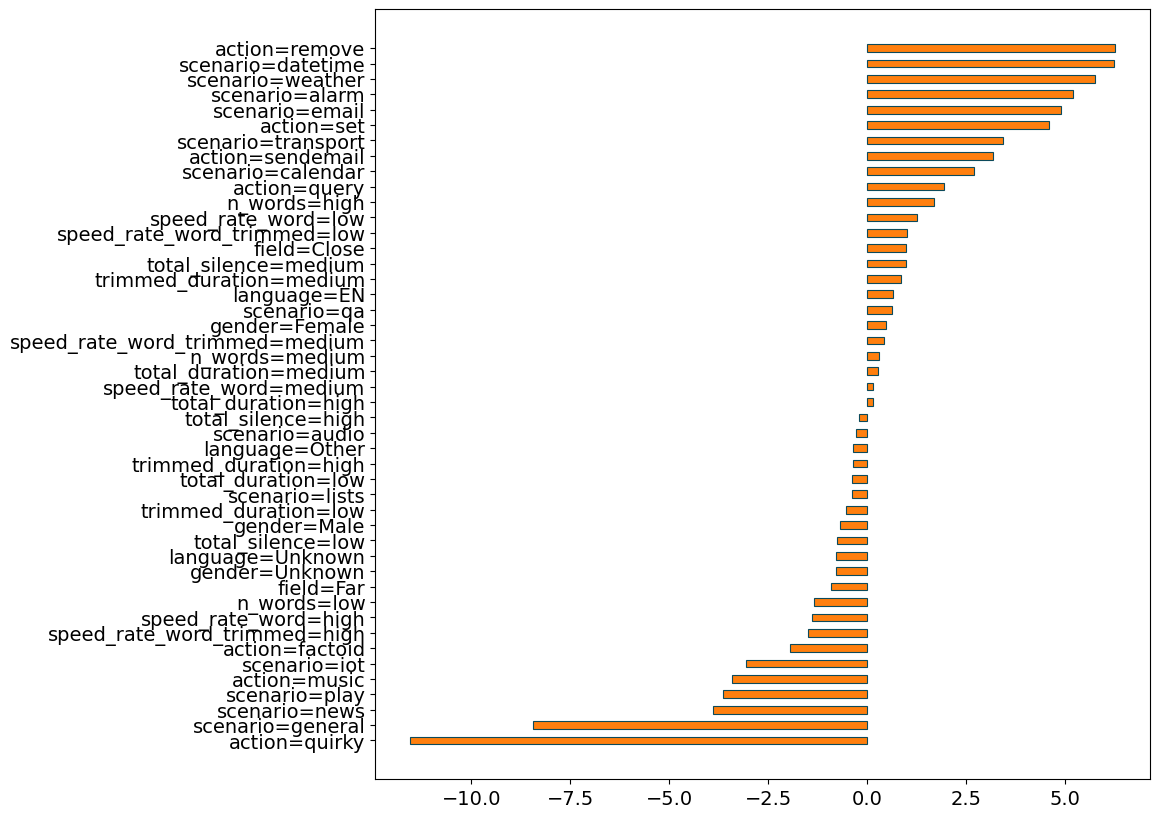

---------------

Global Divergence


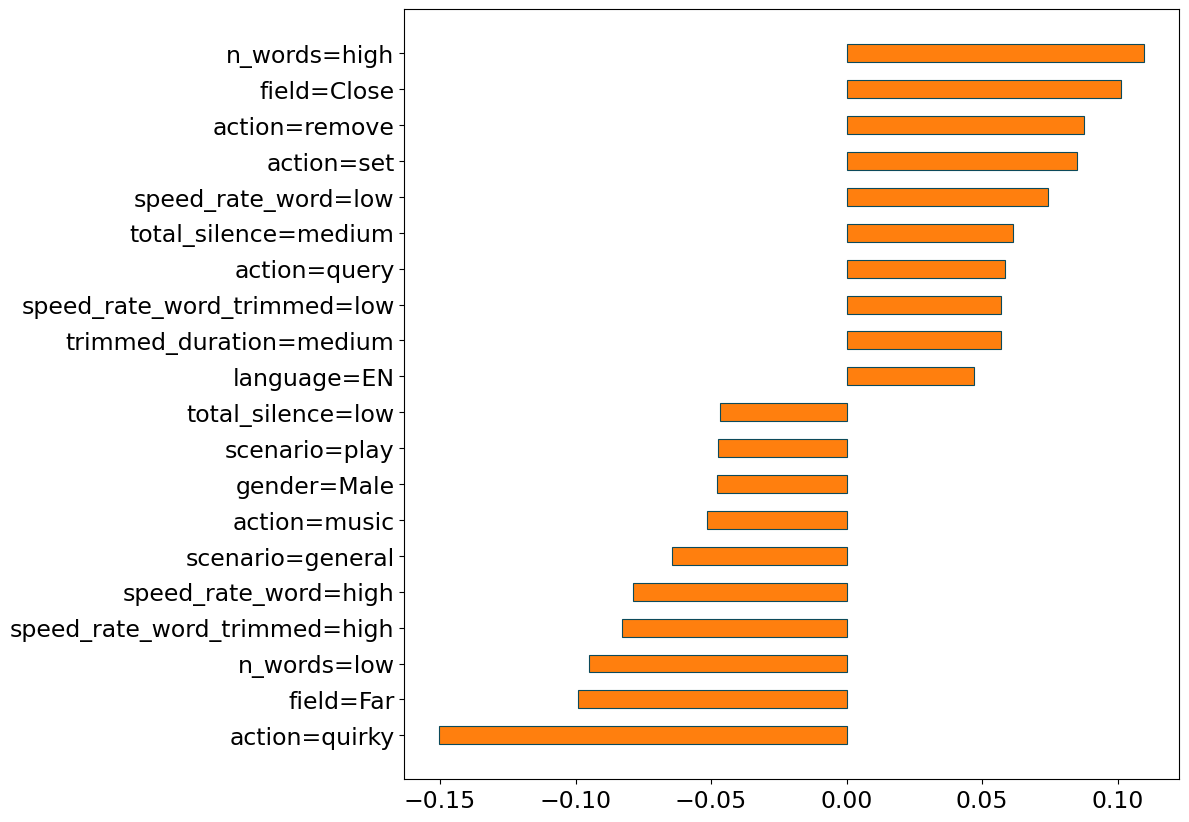

In [41]:
# Individual and Global Divergence
print("Individual Divergence")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=14, titlesize=14)
print("---------------\n")

print("Global Divergence")
global_item_divergence_hubl = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubl = {k:v*100 for k,v in global_item_divergence_hubl.items() 
                    if k in sorted(global_item_divergence_hubl, 
                    key=lambda x: abs(global_item_divergence_hubl[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubl, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

# Divergence difference Wav2Vec2-Base vs Wav2Vec2-Large

In [42]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(wlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [43]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [44]:
## Create "Gain Base-Large W2V2" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [45]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

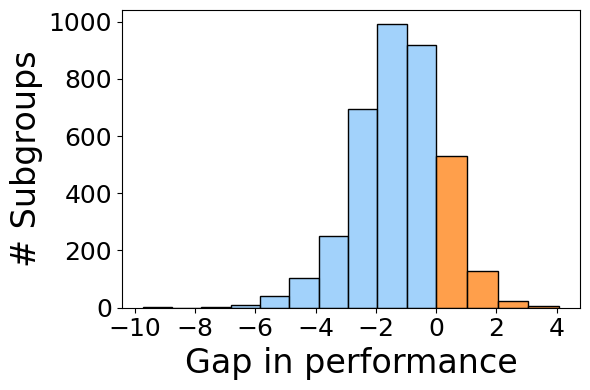

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=4, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/SLURP/distribution_gain_w2v2_base_large.pdf")

## Stats

In [47]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for Wav2Vec2-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for Wav2Vec2-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
3.0287
Greater
16.8634
Lower
80.1078


## Gain > 0

In [48]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"field=Far, language=EN, speakRate_trim=high, trim_dur=high",4.08,83.88,87.96,0.04
1,"speakRate=low, speakRate_trim=medium, tot_dur=medium",3.98,87.59,91.57,0.03


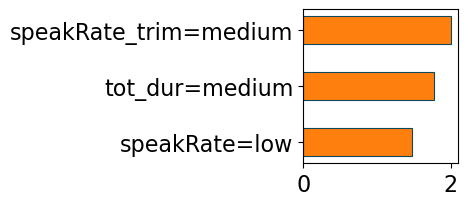

In [49]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [50]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"action=remove, n_words=low",-9.74,92.64,82.90,0.03
1,"gender=Female, language=EN, speakRate=low, tot_dur=low, trim_dur=low",-7.25,86.72,79.47,0.03


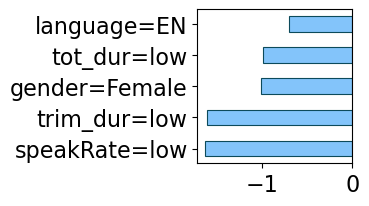

In [51]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [52]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
687,"field=Far, n_words=low, tot_silence=low, trim_dur=low",0.0,79.72,79.72,0.05
686,"gender=Male, language=Other, tot_silence=low",0.0,79.76,79.76,0.04


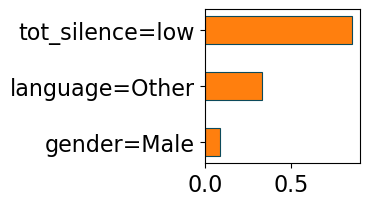

In [53]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [54]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_w2l = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_w2l = {k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(global_item_divergence_w2b_w2l, 
                        key=lambda x: abs(global_item_divergence_w2b_w2l[x]))[::-1][:K]}

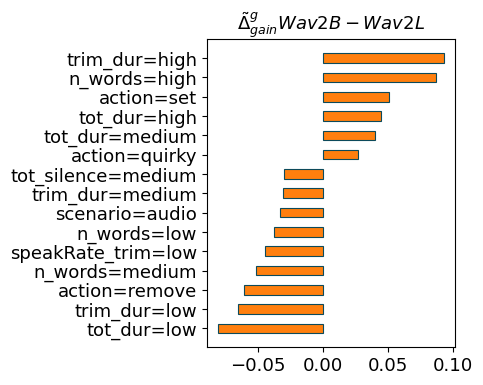

In [55]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_w2l_abbr = abbreviateDict(topK_global_w2b_w2l, abbreviations)
topK_global_w2b_w2l_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_abbr.items()}
name_fig = "plot_results/SLURP/global_shapley_gain_w2b_w2l.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_w2l_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - Wav2L$",
                nameFig=name_fig, saveFig=False)

# Divergence difference HuBERT-Base vs HuBERT-Large

In [56]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for HuBERT-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Merge the df
merged = hbase.join(hlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [57]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [58]:
## Create "Gain Base-Large HuB" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [59]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

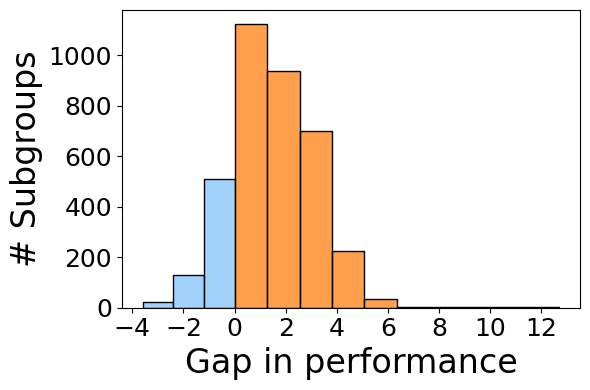

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=3, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/SLURP/distribution_gain_hub_base_large.pdf")

## Stats

In [61]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
2.4384
Greater
81.7762
Lower
15.7854


## Gain > 0

In [62]:
## Retrieve the data cohorts for which HuBERT-Large performs better than HuBERT-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"field=Far, scenario=general",12.69,66.5,79.19,0.03
1,action=quirky,10.50,67.2,77.71,0.05


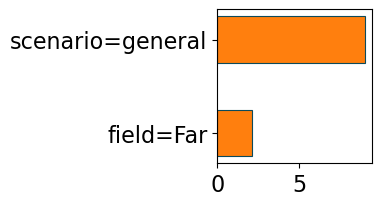

In [63]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [64]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than HuBERT-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"scenario=qa, tot_dur=high",-3.60,89.45,85.85,0.03
1,"n_words=medium, speakRate=medium, tot_silence=high",-3.47,92.10,88.63,0.04


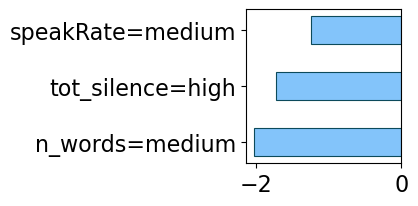

In [65]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [66]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to HuBERT-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
3028,"language=EN, speakRate=medium, tot_dur=medium",0.0,87.57,87.57,0.04
3027,"gender=Male, language=Other, speakRate=medium, speakRate_trim=medium",0.0,87.84,87.84,0.03


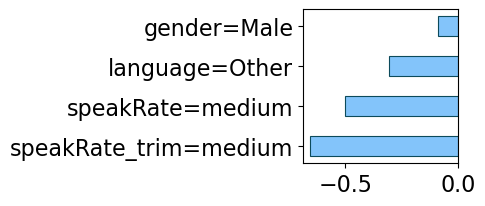

In [67]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [68]:
## Compute the top-K global shapley values related to the gain in performance between HuBERT-Base and HuBERT-Large
global_item_divergence_hb_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_hb_hl = {k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(global_item_divergence_hb_hl, 
                        key=lambda x: abs(global_item_divergence_hb_hl[x]))[::-1][:K]}

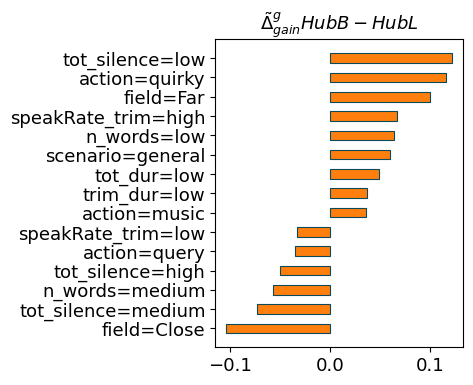

In [69]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_hb_hl_abbr = abbreviateDict(topK_global_hb_hl, abbreviations)
topK_global_hb_hl_abbr = {k:v*100 for k,v in topK_global_hb_hl_abbr.items()}
name_fig = "plot_results/SLURP/global_shapley_gain_hb_hl.pdf"
plotShapleyValue(shapley_values=topK_global_hb_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} HubB - HubL$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec-Base vs HuBERT-Base

In [70]:
## Compute the divergence for HuBERT-Large
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Compute the divergence for wav2vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_wb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_wb.set_index("itemsets")

## Merge the df
merged = wbase.join(hbase, lsuffix='_wbase', rsuffix='_hbase')
merged = merged.rename(columns={'support_hbase': 'support'})

In [71]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hbase"] - merged["accuracy_wbase"]
merged["difference"] = merged["accuracy_hbase"] - merged["accuracy_wbase"]

In [72]:
## Create "Gain w2v2Base-HubBase" df and compute divergence
wbase_hbase_gain_df = merged[['support', '#errors_hbase', '#corrects_hbase', 'accuracy_hbase',
       'd_accuracy_hbase', 't_value_hbase', 'support_count_hbase', 'length_hbase'] \
       + [diff, "difference", "accuracy_wbase"]]
wbase_hbase_gain_df = wbase_hbase_gain_df.rename(columns={'length_hbase':'length'})
wbase_hbase_gain_df = wbase_hbase_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(wbase_hbase_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [73]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_wbase', 'accuracy_hbase', 'support']

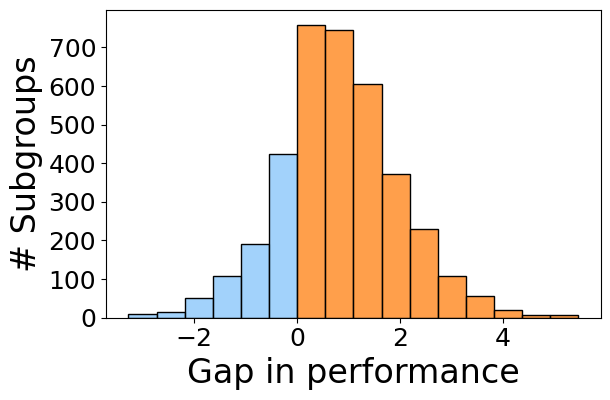

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=6, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.tight_layout()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig("plot_results/SLURP/distribution_gain_w2v2_hub_base.pdf")

## Stats

In [75]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Base
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Base
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
3.8501
Greater
77.1561
Lower
18.9938


## Gain > 0

In [76]:
## Retrieve the data cohorts for which HuBERT-Base performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
0,"field=Far, gender=Male, tot_dur=high, tot_silence=low, trim_dur=high",5.46,80.76,86.22,0.03
1,"gender=Male, tot_dur=high, tot_silence=low, trim_dur=high",5.45,80.57,86.02,0.03


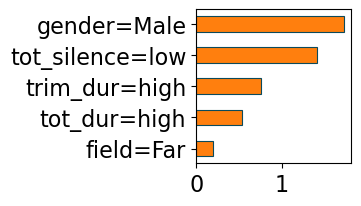

In [77]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [78]:
## Retrieve the data cohorts for which HuBERT-Base performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
0,"field=Far, gender=Female, speakRate=low, tot_dur=low, tot_silence=low",-3.27,85.81,82.53,0.04
1,"scenario=iot, tot_dur=low",-3.24,87.93,84.68,0.04


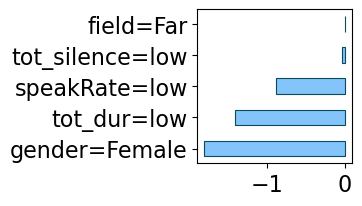

In [79]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [80]:
## Retrieve the data cohorts for which HuBERT-Base performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hbase"] = (pr["accuracy_hbase"]*100).round(2)
pr["accuracy_wbase"] = (pr["accuracy_wbase"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_hbase")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wbase,accuracy_hbase,support
2909,"language=Other, speakRate_trim=high, tot_silence=low, trim_dur=high",0.0,80.55,80.55,0.05
2908,"n_words=low, scenario=play, speakRate_trim=high",0.0,80.98,80.98,0.04


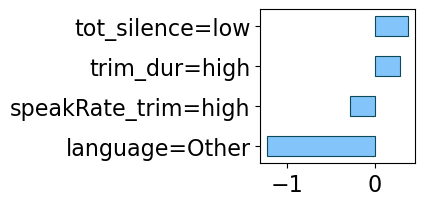

In [81]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [82]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and HuBERT-Base
global_item_divergence_w2b_hb = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_hb = {k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(global_item_divergence_w2b_hb, 
                        key=lambda x: abs(global_item_divergence_w2b_hb[x]))[::-1][:K]}

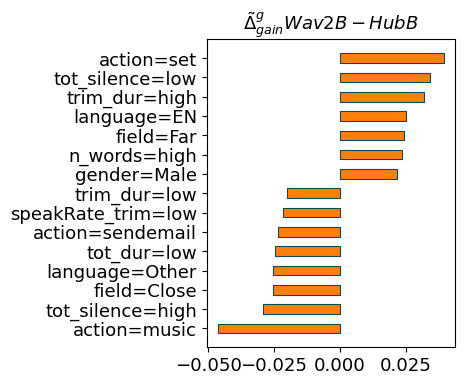

In [83]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_hb_abbr = abbreviateDict(topK_global_w2b_hb, abbreviations)
topK_global_w2b_hb_abbr = {k:v*100 for k,v in topK_global_w2b_hb_abbr.items()}
name_fig = "plot_results/SLURP/global_shapley_gain_w2b_hb.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_hb_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - HubB$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec-Large vs HuBERT-Large

In [84]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for wav2vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_wl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_wl.set_index("itemsets")

## Merge the df
merged = wlarge.join(hlarge, lsuffix='_wlarge', rsuffix='_hlarge')
merged = merged.rename(columns={'support_hlarge': 'support'})

In [85]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hlarge"] - merged["accuracy_wlarge"]
merged["difference"] = merged["accuracy_hlarge"] - merged["accuracy_wlarge"]

In [86]:
## Create "Gain w2v2Large-HubLarge" df and compute divergence
wlarge_hlarge_gain_df = merged[['support', '#errors_hlarge', '#corrects_hlarge', 'accuracy_hlarge',
       'd_accuracy_hlarge', 't_value_hlarge', 'support_count_hlarge', 'length_hlarge'] \
       + [diff, "difference", "accuracy_wlarge"]]
wlarge_hlarge_gain_df = wlarge_hlarge_gain_df.rename(columns={'length_hlarge':'length'})
wlarge_hlarge_gain_df = wlarge_hlarge_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(wlarge_hlarge_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [87]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_wlarge', 'accuracy_hlarge', 'support']

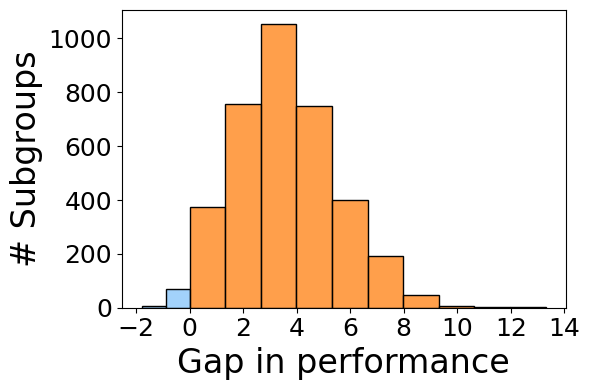

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_neg = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_neg, bins=2, kde=False, ax=ax, color='#83C4FA', palette="colorblind")
list_diff_pos = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/SLURP/distribution_gain_w2v2_hub_large.pdf")

## Stats

In [89]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
1.0524
Greater
97.4333
Lower
1.5144


## Gain > 0

In [90]:
## Retrieve the data cohorts for which HuBERT-Large performs better than Wav2Vec2-Large
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
0,"action=remove, n_words=low",13.30,82.90,96.20,0.03
1,"field=Far, speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low",10.67,76.92,87.59,0.03


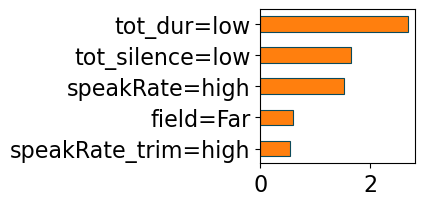

In [91]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [92]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than Wav2Vec2-Large
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
0,"action=query, language=Other, speakRate=medium, speakRate_trim=medium",-1.78,92.13,90.35,0.03
1,"field=Close, speakRate=low, trim_dur=high",-1.30,92.19,90.89,0.04


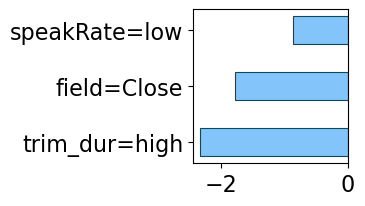

In [93]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [94]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to Wav2Vec2-Large
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hlarge"] = (pr["accuracy_hlarge"]*100).round(2)
pr["accuracy_wlarge"] = (pr["accuracy_wlarge"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("d_difference").sort_values("accuracy_hlarge")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_wlarge,accuracy_hlarge,support
3578,"speakRate_trim=low, tot_dur=high, trim_dur=high",0.0,88.81,88.81,0.03
3577,"field=Close, gender=Female, tot_silence=high, trim_dur=high",0.0,89.14,89.14,0.05


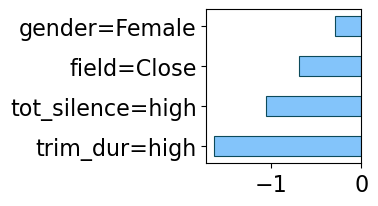

In [95]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [96]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Large and HuBERT-Large
global_item_divergence_w2l_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2l_hl = {k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(global_item_divergence_w2l_hl, 
                        key=lambda x: abs(global_item_divergence_w2l_hl[x]))[::-1][:K]}

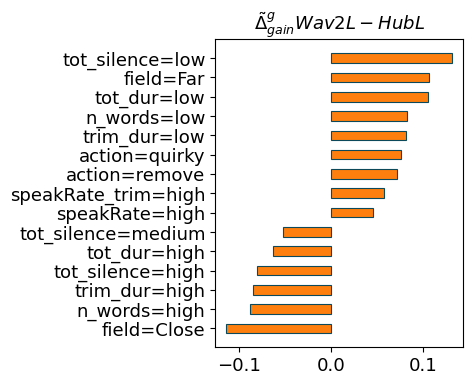

In [97]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2l_hl_abbr = abbreviateDict(topK_global_w2l_hl, abbreviations)
topK_global_w2l_hl_abbr = {k:v*100 for k,v in topK_global_w2l_hl_abbr.items()}
name_fig = "plot_results/SLURP/global_shapley_gain_w2l_hl.pdf"
plotShapleyValue(shapley_values=topK_global_w2l_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2L - HubL$",
                nameFig=name_fig, saveFig=False)

# Global Shapley value comparison

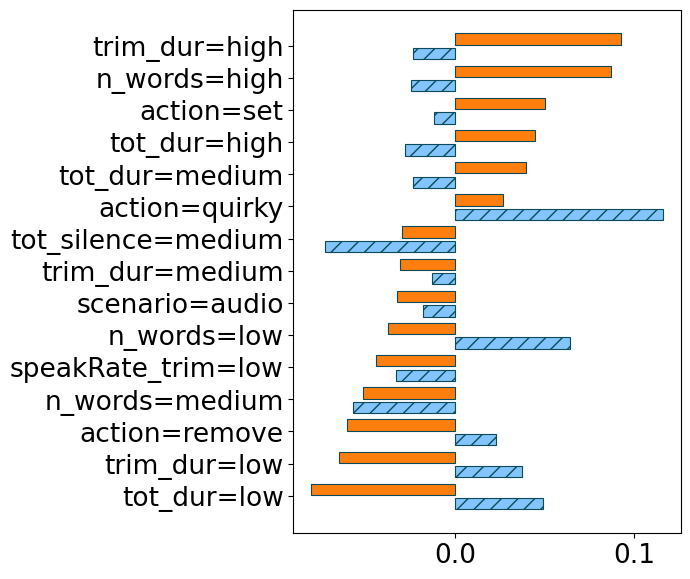

In [98]:
## Take the K Global Shapley Values for HubL-HubB starting from the top-K of WavL-WavB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_hb_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_hb_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_hb_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

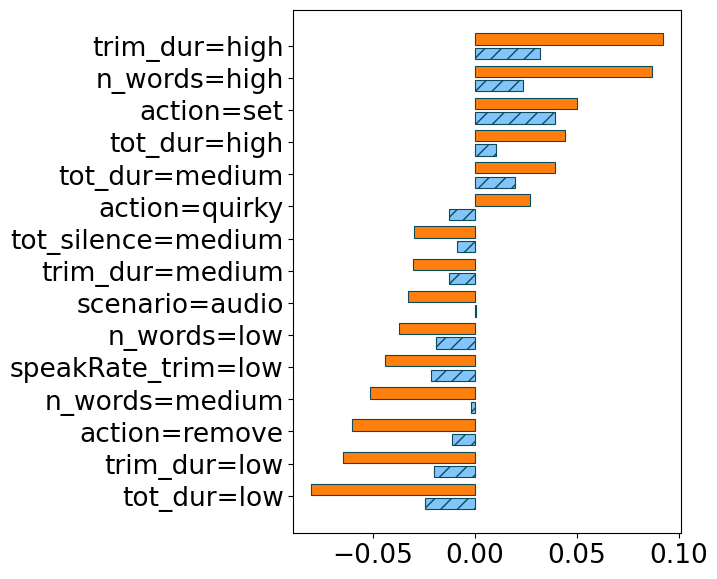

In [99]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)
                        
name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_w2b_hb_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_w2b_hb_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

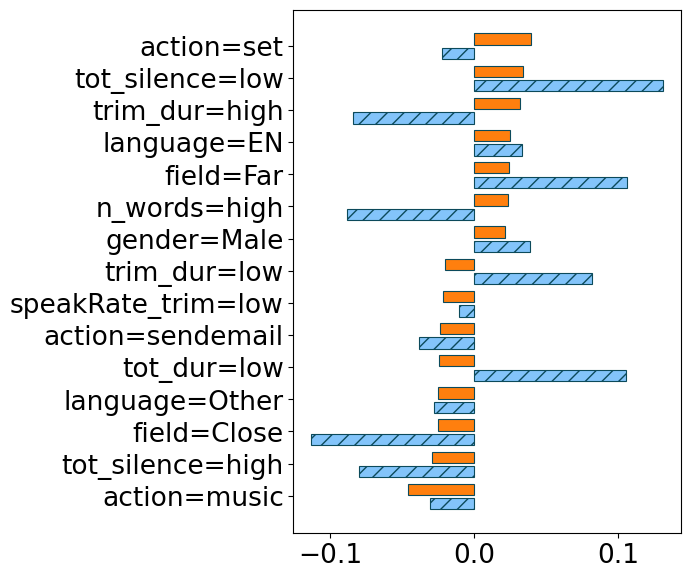

In [100]:
## Take the K Global Shapley Values for WavL-HubL starting from the top-K of WavB-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_hb_w2l_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_hb_abbr, 
            shapley_values_2=topK_global_w2l_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

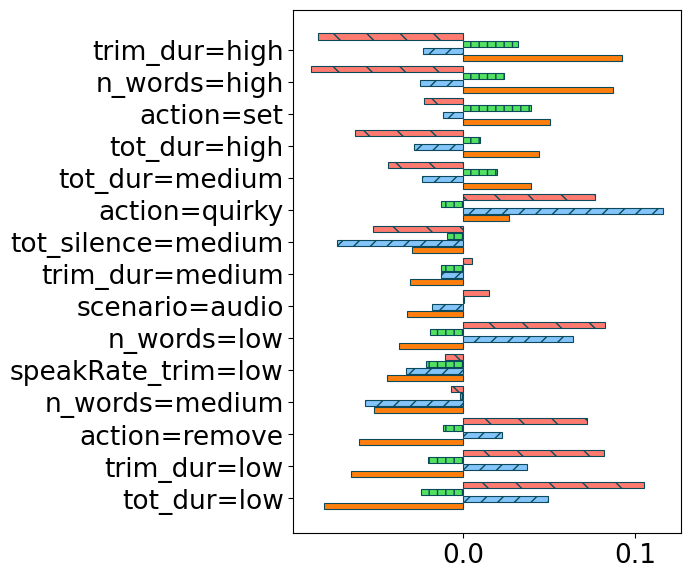

In [101]:
## Take the K Global Shapley Values for HubB-HubL starting from the top-K of WavB-WavL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of WavB-WavL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of WavB-WavL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

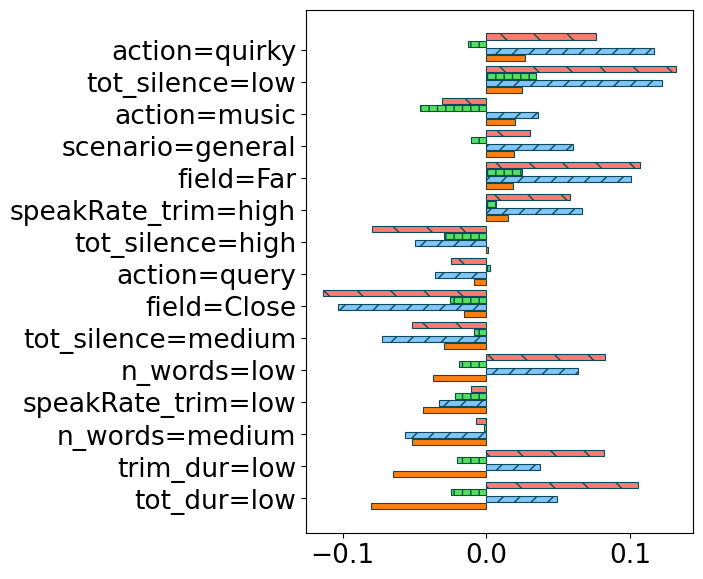

In [102]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of HubB-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of HubB-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of HubB-HubL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

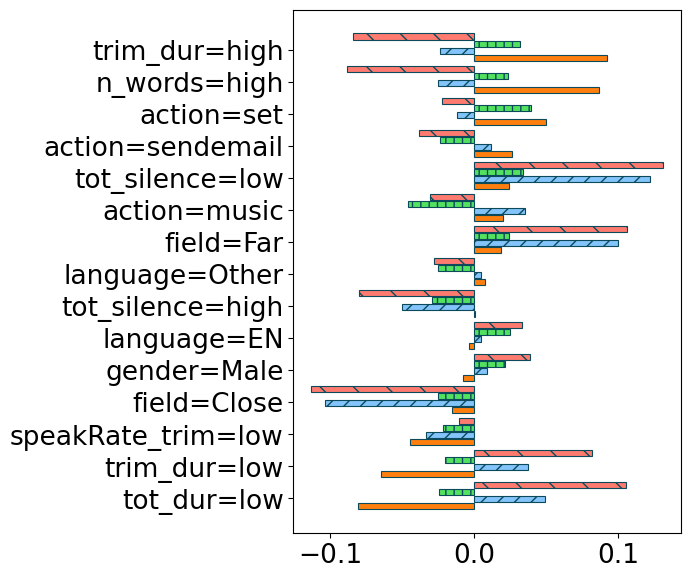

In [103]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2B-HubB
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2B-HubB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of Wav2B-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

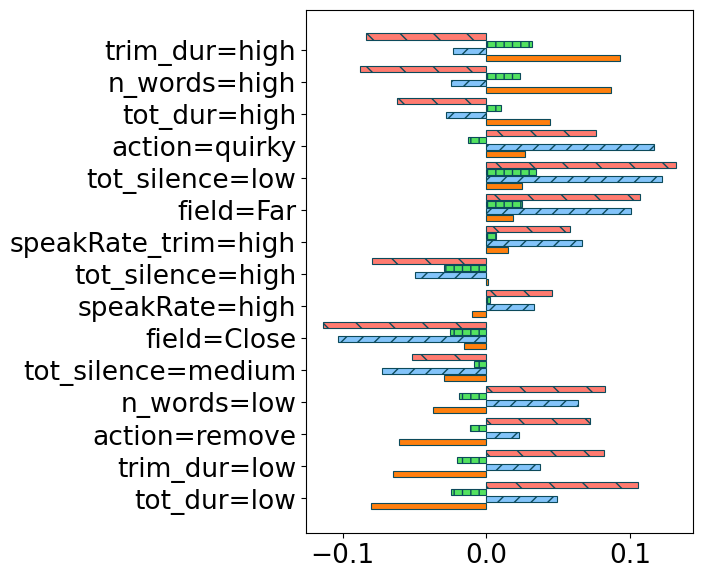

In [104]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2L-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2L-HubL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of Wav2L-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

name_fig = f"plot_results/SLURP/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/SLURP/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)